# 8.1 Base station side: Blind Decoding Of Physical Downlink Control Channel on Plutto-SDR

The tutorial demonstrates the downlink synchronization using synchronization signal block (SSB) and PDCCH blind decoding in 5G networks.
The SSB consists of 4 elements:

- Primary Synchronization Signal (PSS)
- Secondary Synchronization Signal (SSS)
- Physical Broadacast Channel (PBCH) Payload: 432 symbols
- Demodulation Reference Signal (DMRS) for PBCH

The PDCCH consists of 2 elements:
- Define the PDCCH coreset and search space set parameters.
    - Aggregation level
    - frequency domain resources
    - duration
    - monitoring symbols with in a slot
    - search space set type
    - CCE to REG mapping
    - REG bundle size
    - Interleaver size
    - shift index 
    
- Decode the PDCCH candidates blindly based on the chosen parameters.

The tutorial performs following procedures:

- [Import Libraries](#8.1-Import-Libraries)
    - [Import Python Libraries](#8.1-Import-Python-and-SDR-Libraries)
    - [Import 5G Toolkit Libraries](#8.1-Import-5G-Toolkit-Libraries)
- [Emulation Configurations](#8.1-Emulation-Configurations)
- [Construct SSB](#8.1-Generate-the-SSB-Grid-for-synchronization)
    - Generate PSS
    - Generate PSS
    - Generate PBCH
    - Generate DMRS-PBCH
    - Generate SSB
- [CORESET and Search Space Set](#8.1-CORESET-and-Search-Space-Set-Parameters)
- [Display SSB and PDCCH Grid](#8.1-Display-Grids)
- [Constellation Diagram](#8.1-Constellation-Diagram)
- [OFDM Modulation](#8.1-OFDM-Modulation:-Tx)
    - Insert SSB to Tx Resource Grid
    - OFDM Modulation
- [SDR Configuration](#8.1-SDR-Setup-Configurations)
- [Transmit using SDR RF Transmitter](#8.1-Transmission:-SDR-RF-Transmitter)


## 8.1 Import Libraries
### 8.1 Import Python and SDR Libraries

In [1]:
# %matplotlib widget

# from IPython.display import display, HTML
# display(HTML("<style>.container { width:90% !important; }</style>"))

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import numpy as np
import adi
import matplotlib.animation as animation
plt.rcParams['font.size'] = 12
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['font.style'] = 'normal'


### 8.1 Import 5G Toolkit Libraries 

In [2]:
import sys
sys.path.append(".")

from toolkit5G.SequenceGeneration import PSS, SSS, DMRS
from toolkit5G.PhysicalChannels   import PBCH, PBCHDecoder, PDCCH, PDCCHDecoder, PDCCHCandidateBlindDecoding
from toolkit5G.ResourceMapping    import SSB_Grid, ResourceMapperSSB, ResourceMappingPDCCH, CORESET, SearchSpaceSet
from toolkit5G.OFDM               import OFDMModulator, OFDMDemodulator
from toolkit5G.MIMOProcessing     import AnalogBeamforming, ReceiveCombining
from toolkit5G.ReceiverAlgorithms import PSSDetection, SSSDetection, ChannelEstimationAndEqualization, DMRSParameterDetection
from toolkit5G.ReceiverAlgorithms import ChannelEstimationAndEqualizationPBCH, ChannelEstimationAndEqualizationPDCCH
from toolkit5G.Configurations     import TimeFrequency5GParameters, GenerateValidSSBParameters


## 8.1 Emulation Configurations

In [3]:
###################
# System Parameters
###################

center_frequency    = 1*1e9  # center or carrier frequency in Hz
numerology          = 0   
slotNumber          = 0

# OFDM Parameters
Bandwidth           = 20*10**6
fftSize             = 2048
subcarrier_spacing  = 15000
numOFDMSymbols      = 14
sample_rate         = fftSize*subcarrier_spacing

# Pulse Shaping
numSamplesPerSymbol = 1


# number of samples returned per call to rx()
buffer_size         = int(fftSize*1.2*numSamplesPerSymbol*numOFDMSymbols) 

## 8.1 Transmitter Implementation
## 8.1 Generate the SSB Grid for synchronization


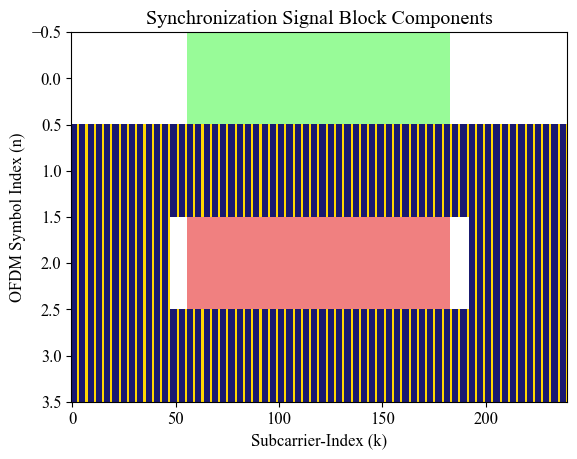

In [4]:
## This class fetches valid set of 5G parameters for the system configurations
nSymbolFrame= int(140*subcarrier_spacing/15000)
## This class fetches valid set of 5G parameters for the system configurations 
tfParams    = TimeFrequency5GParameters(Bandwidth, subcarrier_spacing)
tfParams(nSymbolFrame, typeCP = "normal")
nRB         = tfParams.numRBs        # SSB Grid size (Number of RBs considered for SSB transition)
Neff        = tfParams.Neff        # Number of resource blocks for Resource Grid ( exclude gaurd band | offsets : BWP)
lengthCP    = tfParams.lengthCP    # CP length
#___________________________________________________________________

#### Generate MIB Information
lamda                           = 3e8/center_frequency;
nSCSOffset                      = 1
ssbParameters                   = GenerateValidSSBParameters(center_frequency, nSCSOffset, "caseA", ssbSubCarrierOffset=0, withSharedSpectrumChannelAccess = False)

systemFrameNumber               = ssbParameters.systemFrameNumber
subCarrierSpacingCommon         = subcarrier_spacing
ssbSubCarrierOffset             = ssbParameters.ssbSubCarrierOffset
DMRSTypeAPosition               = ssbParameters.DMRSTypeAPosition
controlResourceSet0             = ssbParameters.controlResourceSet0
searchSpace0                    = ssbParameters.searchSpace0

isPairedBand                    = ssbParameters.isPairedBand
nSCSOffset                      = ssbParameters.nSCSOffset
choiceBit                       = ssbParameters.choiceBit
ssbType                         = ssbParameters.ssbType
nssbCandidatesInHrf             = ssbParameters.nssbCandidatesInHrf
ssbIndex                        = ssbParameters.ssbIndex
hrfBit                          = ssbParameters.hrfBit
cellBarred                      = ssbParameters.cellBarred
intraFrequencyReselection       = ssbParameters.intraFrequencyReselection
withSharedSpectrumChannelAccess = ssbParameters.withSharedSpectrumChannelAccess

Nsc_ssb                         = 240
Nsymb_ssb                       = 4


N_ID2        = np.random.randint(3)

# Generate PSS sequence
pssObject    = PSS(N_ID2);
pssSequence  = pssObject()

N_ID1        = np.random.randint(336)
N_ID         = 3*N_ID1 + N_ID2

# Generate SSS sequence
sssObject    = SSS(N_ID1, N_ID2);
sssSequence  = sssObject()

# Generate DMRS sequence
dmrsLen      = 144;
dmrsObject   = DMRS("PBCH", N_ID, ssbIndex, nssbCandidatesInHrf, hrfBit)
# dmrsSeq = dmrs.getSequence("tensorflow")
dmrsSequence = dmrsObject(dmrsLen)


# Generate PBCH symbols
pbchObject   = PBCH(center_frequency, choiceBit, subCarrierSpacingCommon, DMRSTypeAPosition,
                   controlResourceSet0, searchSpace0, cellBarred, intraFrequencyReselection,
                   systemFrameNumber, ssbSubCarrierOffset, hrfBit, ssbIndex, N_ID,
                   nssbCandidatesInHrf)

pbchSymbols  = pbchObject()

## Generate SSB Object
ssbObject    = SSB_Grid(N_ID, True)
ssb          = ssbObject(pssSequence, sssSequence, dmrsSequence, pbchSymbols)

## Loading SSB to Resource Grid
#####################################
# ssbPositionInBurst = np.ones(nssbCandidatesInHrf, dtype=int)
ssbPositionInBurst    = np.zeros(nssbCandidatesInHrf, dtype=int)
ssbPositionInBurst[0] = 1

ssbRGobject    = ResourceMapperSSB(ssbType=ssbType, carrierFrequency = center_frequency, 
                                   isPairedBand = isPairedBand, 
                                   withSharedSpectrumChannelAccess = withSharedSpectrumChannelAccess)

ssbGrid = ssbRGobject(ssb[0], ssbPositionInBurst, offsetInSubcarriers = ssbSubCarrierOffset,
                      offsetInRBs = 70, numRBs = nRB)[0:14]
fig, ax = ssbObject.displayGrid(option=1)


In [5]:
nssbCandidatesInHrf

4

### 8.1 CORESET and Search Space Set Parameters

In [6]:
AggLevel = 2

monitoringSymbolsWithinSlot = np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype = int)
startSymIndex               = np.nonzero(monitoringSymbolsWithinSlot)[0][0]

coresetID       = 1
cce_reg_Mapping = "interleaved" # CCE to REG mapping type
L               = 6             # REG-bundle size 
R               = 2             # Interleaver size 
nshift          = 0             # cyclic-shift index after interleaving

duration        = 1             # duration of CORESET 
frequencyDomainResources = np.array([1,1,1,1,1,1,1,1,1,
                                     1,1,1,1,1,1,1,1,1,
                                     0,0,0,0,0,0,0,0,0,
                                     0,0,0,0,0,0,0,0,0,
                                     0,0,0,0,0,0,0,0,0], dtype = int) 

RNTI         = 0

In [7]:
coresetObj = CORESET(duration,frequencyDomainResources)
coresetPRBIndices = coresetObj(cce_REG_MappingType = cce_reg_Mapping, 
                               reg_BundleSize=L, interleaverSize = R, shiftIndex = nshift)
ssType                   = "USS"
AggLevel                 = 16                                 # Aggregation level
coresetSize              = coresetObj.numCCESInCoreset       # CORESET size in number of CCEs
numCandidatesPerAL       = np.array([4,4,2,2,1], dtype=int)  # number of pdcch candidates per Aggregation Level.
ssObj = SearchSpaceSet(numerology = numerology, searchSpaceType = ssType, 
                       numCandidates = numCandidatesPerAL, coresetDuration = duration)

##############
# CCE indices
##############

M      = numCandidatesPerAL[int(np.log2(AggLevel))]    
ueCand = ssObj(AggLevel,RNTI,coresetSize,slotNumber,coresetID)
ueCCEs = ueCand[np.random.randint(M)]

        
        
print("#####################################################################")        
print("Duration of CORESET:", duration)
print()
print("Frequency Domain Resources:", frequencyDomainResources)
print()
print("CORESET size in CCEs:", coresetObj.numCCESInCoreset)
print()
print("Monitoring Symbols With in a Slot:", monitoringSymbolsWithinSlot)
print()
print("CORESET Start symbol index:", startSymIndex)
print()
print("#####################################################################")
print("Candidates Corresponding to UE with a chosen Aggregation Level of " + str(AggLevel) + ":\n", ueCand)
print()
print("CCEs Corresponding to UE:\n", ueCCEs)

#####################################################################
Duration of CORESET: 1

Frequency Domain Resources: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0]

CORESET size in CCEs: 18

Monitoring Symbols With in a Slot: [1 0 0 0 0 0 0 0 0 0 0 0 0 0]

CORESET Start symbol index: 0

#####################################################################
Candidates Corresponding to UE with a chosen Aggregation Level of 16:
 [[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]]

CCEs Corresponding to UE:
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


In [8]:
nBatches     = 1                   # number of batches 
numPDCCHSym  = int(54*AggLevel)    # number of REs occupied by PDCCH data (QPSK symbols)
numPDCCHdmrs = int(18*AggLevel)    # number of REs occupied by PDCCH DMRS symbols
E            = numPDCCHSym*2       # number of target Bits
K            = 20                  # payload size in bits
dciBits      = np.random.randint(0, 2, [nBatches, K]) 

##############################################
# PDCCH chain and generation of  QPSK symbols
##############################################
pdcchObj = PDCCH(K, E, RNTI, N_ID)
symb     = pdcchObj(dciBits) 

###################
# Resource Mappping
###################
rmPDCCH      = ResourceMappingPDCCH(numerology, frequencyDomainResources, duration, monitoringSymbolsWithinSlot)
pdcchGrid    = rmPDCCH(symb, cce_reg_Mapping, L, R, nshift, slotNumber, N_ID, ueCCEs)


In [9]:
pdcchGrid.shape, N_ID

((1, 14, 3240), 47)

### 8.1 Display Grids

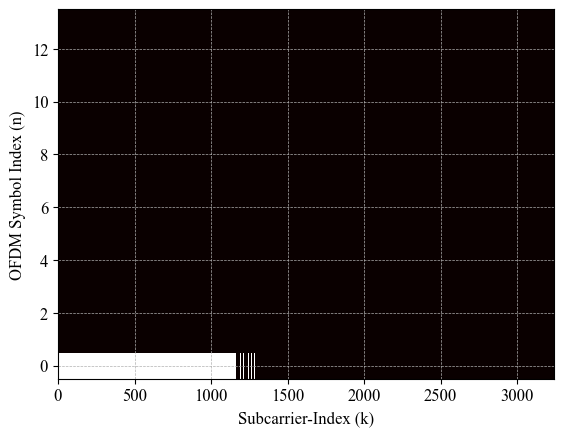

In [10]:
fig, ax = plt.subplots()
colors  = ['palegreen', 'white', 'lightcoral', 'gold', 'midnightblue', 'purple']



# Grid  = pdcchGrid[0][...,0:ssbGrid.shape[-1]]
Grid  = pdcchGrid[0]
plt.imshow(np.abs(Grid), interpolation='none', aspect = "auto", cmap="hot", origin='lower')


ax.tick_params(axis='both',which='minor', grid_linewidth=  2, width=0)
ax.tick_params(axis='both',which='major', grid_linewidth=0.5, grid_linestyle = '--')
ax.grid(which='both')
ax.set_xlabel("Subcarrier-Index (k)")
ax.set_ylabel("OFDM Symbol Index (n)")

plt.show()

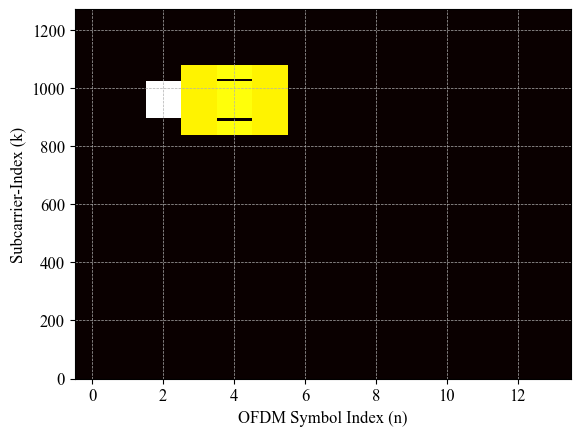

In [11]:
fig, ax = plt.subplots()
colors  = ['palegreen', 'white', 'lightcoral', 'gold', 'midnightblue', 'purple']
bounds  = [0,1,2,3,4,5,6]

plt.imshow(np.abs(ssbGrid.T), interpolation='none', aspect = "auto", cmap="hot", origin='lower')


ax.tick_params(axis='both',which='minor', grid_linewidth=  2, width=0)
ax.tick_params(axis='both',which='major', grid_linewidth=0.5, grid_linestyle = '--')
ax.grid(which='both')
ax.set_ylabel("Subcarrier-Index (k)")
ax.set_xlabel("OFDM Symbol Index (n)")

plt.show()

In [12]:
# resourceGrid = ssbGrid
# resourceGrid = resourceGrid + np.sqrt(1/127)*pdcchGrid[0,:,0:Neff]  # make sure that the merged grids of SSB and PDCCH do not overlap.
resourceGrid = np.concatenate([ssbGrid, np.sqrt(1/127)*pdcchGrid[0,:,0:Neff]], axis = 0) # make sure that the merged grids of SSB and PDCCH do not overlap.

In [13]:
resourceGrid.shape

(28, 1272)

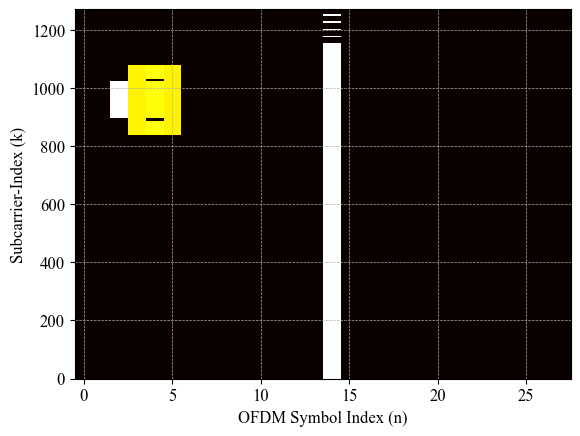

In [14]:
fig, ax = plt.subplots()
colors  = ['white', 'palegreen', 'lightcoral', 'gold', 'midnightblue', 'purple']
bounds  = [0,1,2,3,4,5,6]

plt.imshow(np.abs(resourceGrid.T), interpolation='none', aspect = "auto", cmap="hot", origin='lower')


ax.tick_params(axis='both',which='minor', grid_linewidth=  2, width=0)
ax.tick_params(axis='both',which='major', grid_linewidth=0.5, grid_linestyle = '--')
ax.grid(which='both')
ax.set_ylabel("Subcarrier-Index (k)")
ax.set_xlabel("OFDM Symbol Index (n)")

plt.show()

## 8.1 Constellation Diagram

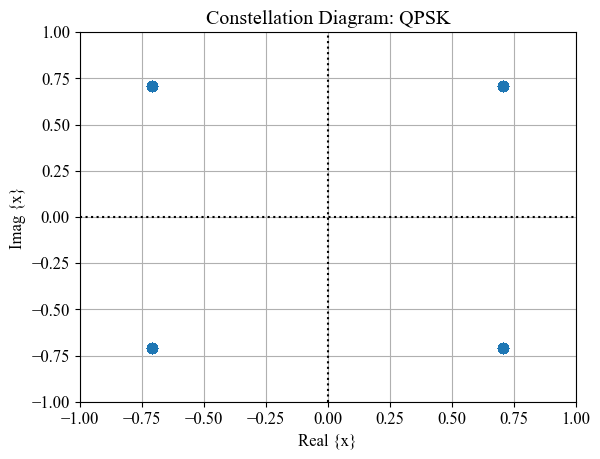

In [15]:
fig, ax = plt.subplots()
ax.scatter(np.real(pbchSymbols),  np.imag(pbchSymbols), s=48)
ax.axhline(y=0, ls=":", c="k")
ax.axvline(x=0, ls=":", c="k")
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_xlabel("Real {x}")
ax.set_ylabel("Imag {x}")
ax.set_title("Constellation Diagram: QPSK")
ax.grid()
plt.show()

## 8.1 OFDM Modulation: Tx

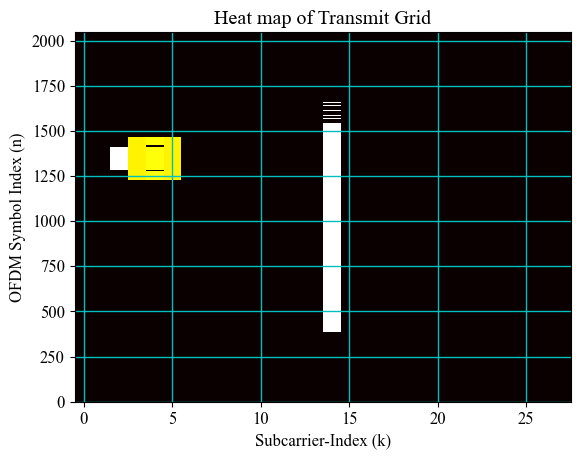

In [16]:
## Loading SSB to Resource Grid
numofGuardCarriers = (int((fftSize - Neff)/2), int((fftSize - Neff)/2))
offsetToPointA     = 0
firstSCIndex       = int(numofGuardCarriers[0] + offsetToPointA)
numOFDMSymbols     = resourceGrid.shape[0]

X = np.zeros((numOFDMSymbols, fftSize), dtype= np.complex64)
X2 = np.zeros((numOFDMSymbols, fftSize), dtype= np.complex64)
X[:, firstSCIndex:firstSCIndex+ssbGrid.shape[-1]] = resourceGrid
#__________________________________________________

## OFDM Modulation at Transmitter
#####################################
modulator = OFDMModulator(lengthCP[1])
x_time    = modulator(X).flatten()
#______________________________________________________

# Plot Resource Grid
#################################################################
fig, ax = plt.subplots()
plt.imshow(np.abs(X).T, cmap = 'hot', interpolation='nearest', aspect = "auto", origin = "lower")
ax = plt.gca();
ax.grid(color='c', linestyle='-', linewidth=1)
ax.set_xlabel("Subcarrier-Index (k)")
ax.set_ylabel("OFDM Symbol Index (n)")
ax.set_title("Heat map of Transmit Grid")
# Gridlines based on minor ticks
plt.show()

## 8.1 SDR-Setup Configurations

In [17]:
# Basic SDR Setup
sdr = adi.Pluto("ip:192.168.3.1")
sdr.sample_rate = int(sample_rate)

# Config Tx
sdr.tx_rf_bandwidth = int(sample_rate) # filter cutoff, just set it to the same as sample rate
sdr.tx_lo           = int(center_frequency)
sdr.tx_hardwaregain_chan0 = 0 # Increase to increase tx power, valid range is -90 to 0 dB

## 8.1 Transmission: SDR RF Transmitter

In [18]:
sdr.tx_destroy_buffer()
# Start the transmitter
sdr.tx_cyclic_buffer = True # Enable cyclic buffers

scale = 2.5*2**16
# sdr.tx_cyclic_buffer = False # Enable cyclic buffers
sdr.tx(scale*(x_time.repeat(1))) # start transmitting


In [19]:
np.max(np.abs(scale*(x_time.repeat(1))))

34195.19495057996

In [20]:
firstSCIndex 

388